<a href="https://colab.research.google.com/github/tangQAQ/LSTM_training/blob/main/LSTM_InRange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy
from sklearn.model_selection import train_test_split
class data_process:
  def __init__(self):
    pass
    
  # Make the split data and slice sequences at the same time
  def split_sequences(self, data, slice_size, sequences):
    train, val = train_test_split(data, train_size = slice_size, shuffle = False)

    X_train, y_train = self.create_sequences(train, sequences)
    X_val, y_val = self.create_sequences(val, sequences)
    return X_train, y_train, X_val, y_val 

  # Slice sequences with a independent function
  def create_sequences(self, data, sequences):
    X = []
    y = []
    for i in range(sequences, len(data)):
        X.append(data.iloc[i-sequences:i, :])
        y.append(data.iloc[i, :])
    X = numpy.array(X)
    y = numpy.array(y)
    return X, y

In [ ]:
import pandas

class read_process:
  def __init__(self):
    self.min = None
    self.interval = None
    self.step= None
  
  # The data that we craw values are string so here make it be float32 data type
  def read_process(self, data):
    Time = pd.to_datetime(data['Date'])
    data = data.drop(['Date'], axis=1)
    data = data.apply(lambda x: pd.to_numeric(x.str.replace(',',''), errors='coerce')).fillna(-1).astype('float32')
    data = pd.concat([Time, data], axis=1)
    return data
  
  # We are making the features for classification with pct_change values that refer to the Close column
  def feature_train(self, data, step):
    data['Pct_change'] = data['Close'].pct_change()
    data.drop(data.index[0], inplace=True)
    data['feature_check'] = data['Pct_change']
    data['feature'], interval = self.replace_values(data, step)
    final_feature = data['feature'].value_counts().nlargest(3).index.tolist()
    data['final_feature'] = data['feature'].apply(lambda x: x if x in final_feature else np.nan)
    data.dropna(subset=['final_feature'], inplace=True)
    print(data['final_feature'].shape)
    return data, interval

  def replace_values(self, data, step):
    data = data['feature_check'].values
    self.step = step
    min = data.min()
    self.min = min
    max = data.max()
    interval = (max-min)/step
    self.interval = interval
    result = list()
    for value in data:
      interval_index = int((value - min) / interval)
      if interval_index ==20:
         interval_index = 19
      result.append(interval_index)
    return result, interval

  def feature_test(self, data):
    data['Pct_change'] = data['Close'].pct_change()
    data.drop(data.index[0], inplace=True)
    data['feature_check'] = data['Pct_change']
    data['feature'] = self.transform(data)
    # 提取前三高出現的數值作為模型的test data
    data_final_feature = data['feature'].value_counts().nlargest(3).index.tolist()
    data['final_feature'] = data['feature'].apply(lambda x: x if x in data_final_feature else np.nan)
    data.dropna(subset=['final_feature'], inplace=True)
    print(data['final_feature'].shape)
    return data

  def transform(self, data):
    data = data['feature_check'].values
    result = list()
    for value in data:
      interval_index = int((value - self.min) / self.interval)
      if interval_index ==20:
         interval_index = 19
      result.append(interval_index)
    return result

  def decode_replace_values(self, inverse):
    data = []
    for i in inverse:
        value = self.min + i * self.interval
        data.append(value)
    return data

In [ ]:
import matplotlib.pyplot as plt

  # Start with the keras model we using the Sequential to combine the layers first
  # For the layers design we are using 4 LSTM layers for the TimeSeries for each 64 units
  # And last make a dense layer to compress the column to the OneHotencoder shape
  # In this model we choose Adam and categorical_crossentropy for optimizer and loss_function
  # When the model training here take accuracy for metrics
  # We hope the model won't be overfitting so we take a callback for EarlyStopping to monitor the loss and val_loss
  # At last take a history to make a graph to watch the loss and accuracy in both of train and validation 

class Model_patten:
  def __init__(self, X_train, y_train, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val
        self.model = Sequential()
        self.model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        self.model.add(LSTM(units=64, return_sequences=True))
        self.model.add(LSTM(units=64, return_sequences=True))
        self.model.add(LSTM(units=64, return_sequences=False))
        self.model.add(Dense(units=X_train.shape[2], activation='softmax'))
        self.model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
        # callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.history = self.model.fit(X_train, y_train, validation_data=(self.X_val, self.y_val), epochs=10, batch_size=32)#, callbacks=[callback])

  def get_loss(self):
    plt.plot(self.history.history['loss'])
    plt.plot(self.history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.savefig('NASDAQ_Loss.png')

  def get_acc(self):
    plt.plot(self.history.history['accuracy'])
    plt.plot(self.history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.savefig('NASDAQ_Accuracy.png')

  def distribution(self):
    y_pred = self.model.predict(self.X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(np.argmax(self.y_val, axis=1), y_pred_classes)
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, cmap='Blues')
    cbar = ax.figure.colorbar(im, ax=ax)
    # class_name = ['2' ,'3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
    ax.set(xticks = np.arange(cm.shape[1]),
           yticks = np.arange(cm.shape[0]),
          #  xticklabels = class_name,
          #  yticklabels = class_name,
           xlabel='Predicted label',
           ylabel='True label',
           title='Confusion matrix')
    ax.tick_params(axis='x', rotation=45)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha = 'center', va = 'center',
                color = 'white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    plt.show()

  def predict(self, X_test):
    return self.model.predict(X_test)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy
import pandas

# For the model preprocessing we take the OneHotEncoder for the features
# Here is fit_transform the train data and transform test data then decode the predict values
class OHEncoder:
  def __init__(self):
    self.enc = None

  def Encoder(self, data):
    data_copy = data.copy()
    enc = OneHotEncoder(sparse=False)
    one_hot = enc.fit_transform(data_copy.values.reshape(-1, 1))
    one_hot_df = pandas.DataFrame(one_hot)
    self.enc = enc
    return one_hot_df

  def transform(self, data):
    transform = self.enc.transform(data.values.reshape(-1, 1))
    tr = pandas.DataFrame(transform)
    return tr

  def Decoder(self, data):
    data_dec = numpy.eye(data.shape[1])[data.argmax(axis=1)]
    return self.enc.inverse_transform(data_dec)

In [ ]:
import matplotlib.pyplot as plt

# For compare the predict values with Actual values we make a graph that
# xlabel : Time line
# ylabel : Pct_change (Cause our feature has 22 columns so here make a ylimit that watching much more easier)
# For the red line is Actual Feature and the blue line is Predicted Feature 

class PlotGraph:
    def __init__(self):
        pass
    
    def predict_graph(self, result, actual, timestep):
        plt.figure(figsize=(12, 8))
        plt.title(f'Actual vs. Predicted Pct_change Prices(Timestep {timestep})')
        plt.xlabel('Time line')
        plt.ylabel('Pct_change')
        plt.plot(result, label='Predicted Feature', color='b', linestyle='--')
        plt.plot(actual, label='Actual Feature', color='r')
        # plt.ylim([-12, 12])
        plt.legend()
        plt.show()
        plt.savefig('NASDAQ_PCT_Prediction.png')

In [ ]:
# import side
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from google.colab import drive
import warnings 

warnings.filterwarnings('ignore')

In [ ]:
# Reading data and turn into dataframe 
drive.mount('/content/gdrive')
raw_data = pd.read_csv("/content/gdrive/MyDrive/GSPC_train.csv")
raw_data = raw_data.astype(dtype=str)

rp = read_process()
rp_7 = read_process()
raw_data = rp_7.read_process(raw_data)

all = len(raw_data)
predict = 20
bin = 9


train_data = raw_data[:all - predict]

test_data_7 = raw_data[all - predict - 7 -1:]
test_data_15 =  raw_data[all - predict - 15 -1:]
test_data_30 =  raw_data[all - predict - 30 -1:]

# train_feature = pd.DataFrame()
train_feature, interval = rp_7.feature_train(train_data, bin)

Actual_data, interval = rp.feature_train(raw_data, bin)
#Actual_feature = Actual_data[all - predict:].reset_index()
Actual_feature = Actual_data.tail(predict).reset_index()
Actual_feature

Mounted at /content/gdrive
(23526,)
(23546,)


,index,Date,Open,High,Low,Close,Adj Close,Volume,Pct_change,feature_check,feature,final_feature
0,23663,2022-03-16,4288.140137,4358.899902,4251.990234,4357.859863,4357.859863,6.309750e+09,0.022384,2.0,5,5.0
1,23664,2022-03-17,4345.109863,4412.669922,4335.649902,4411.669922,4411.669922,4.985090e+09,0.012348,1.0,5,5.0
2,23665,2022-03-18,4407.339844,4465.399902,4390.569824,4463.120117,4463.120117,8.278430e+09,0.011662,1.0,5,5.0
3,23666,2022-03-21,4462.399902,4481.750000,4424.299805,4461.180176,4461.180176,4.869820e+09,-0.000435,-0.0,4,4.0
4,23667,2022-03-22,4469.100098,4522.000000,4469.100098,4511.609863,4511.609863,4.754840e+09,0.011304,1.0,5,5.0
5,23668,2022-03-23,4493.100098,4501.069824,4455.810059,4456.240234,4456.240234,4.550670e+09,-0.012273,-1.0,4,4.0
6,23669,2022-03-24,4469.979980,4520.580078,4465.169922,4520.160156,4520.160156,4.131390e+09,0.014344,1.0,5,5.0
7,23670,2022-03-25,4522.910156,4546.029785,4501.069824,4543.060059,4543.060059,4.305020e+09,0.005066,1.0,5,5.0
8,23671,2022-03-28,4541.089844,4575.649902,4517.689941,4575.520020,4575.520020,4.312260e+09,0.007145,1.0,5,5.0
9,23672,2022-03-29,4602.859863,4637.299805,4589.660156,4631.600098,4631.600098,5.085910e+09,0.012257,1.0,5,5.0


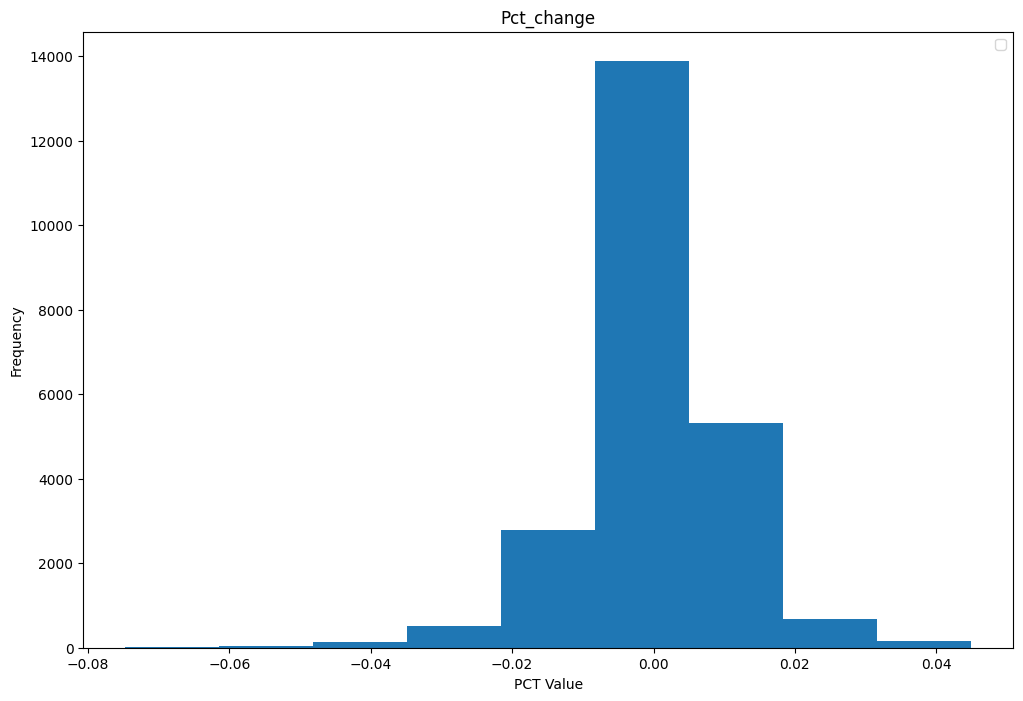

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Pct_change')
plt.xlabel('PCT Value')
plt.ylabel('Frequency')
plt.hist(Actual_data['Pct_change'], bins=bin)
plt.legend()
plt.show()
plt.savefig('NASDAQ_PCT_Histogram.png')

In [ ]:
train_feature['feature'].value_counts()

4    17156
5     6174
3      196
Name: feature, dtype: int64

In [ ]:
# final_feature = train_data['feature'].value_counts().nlargest(3).index.tolist()
# train_data['final_feature'] = train_data['feature'].apply(lambda x: x if x in final_feature else np.nan)
# train_feature.dropna(subset=['final_feature'], inplace=True)
# print(train_feature['final_feature'].shape)

In [ ]:
train_feature['feature'].shape

(23526,)

In [ ]:
# Cause the web crawler has some trouble so before the preprocess data we need to convert the value type first
# Then make the feature with pct_change

# train_feature = rp.feature(train_data)

# Here start preprocessing with OneHotEncoder for the feature column
enc_7 = OHEncoder()
enc_15 = OHEncoder()
enc_30 = OHEncoder()

ohe_7 = enc_7.Encoder(train_feature['final_feature'])
ohe_15 = enc_15.Encoder(train_feature['final_feature'])
ohe_30 = enc_30.Encoder(train_feature['final_feature'])

# After transform the feature to OneHotEncoder we are going to make the train, validation split and slice the Timestep to sequences
dp = data_process()
X_train_7, y_train_7, X_val_7, y_val_7 = dp.split_sequences(ohe_7, 0.8, 7)
X_train_15, y_train_15, X_val_15, y_val_15 = dp.split_sequences(ohe_15, 0.8, 15)
X_train_30, y_train_30, X_val_30, y_val_30 = dp.split_sequences(ohe_30, 0.8, 30)

In [ ]:
X_train_7.shape

(18813, 7, 3)

Epoch 1/10
588/588 [==============================] - 20s 13ms/step - loss: 0.6280 - accuracy: 0.7298 - val_loss: 0.6309 - val_accuracy: 0.7242
Epoch 2/10
588/588 [==============================] - 5s 9ms/step - loss: 0.6178 - accuracy: 0.7304 - val_loss: 0.6204 - val_accuracy: 0.7242
Epoch 3/10
588/588 [==============================] - 6s 10ms/step - loss: 0.6164 - accuracy: 0.7303 - val_loss: 0.6153 - val_accuracy: 0.7242
Epoch 4/10
588/588 [==============================] - 5s 9ms/step - loss: 0.6146 - accuracy: 0.7304 - val_loss: 0.6148 - val_accuracy: 0.7242
Epoch 5/10
588/588 [==============================] - 5s 9ms/step - loss: 0.6123 - accuracy: 0.7303 - val_loss: 0.6167 - val_accuracy: 0.7242
Epoch 6/10
588/588 [==============================] - 6s 10ms/step - loss: 0.6110 - accuracy: 0.7306 - val_loss: 0.6169 - val_accuracy: 0.7242
Epoch 7/10
588/588 [==============================] - 5s 9ms/step - loss: 0.6106 - accuracy: 0.7303 - val_loss: 0.6174 - val_accuracy: 0.7238
Ep

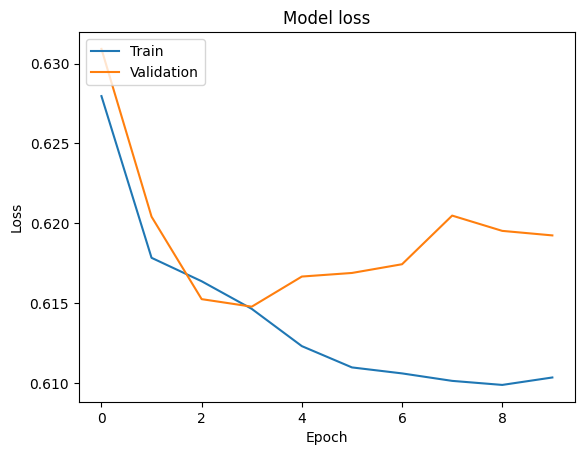

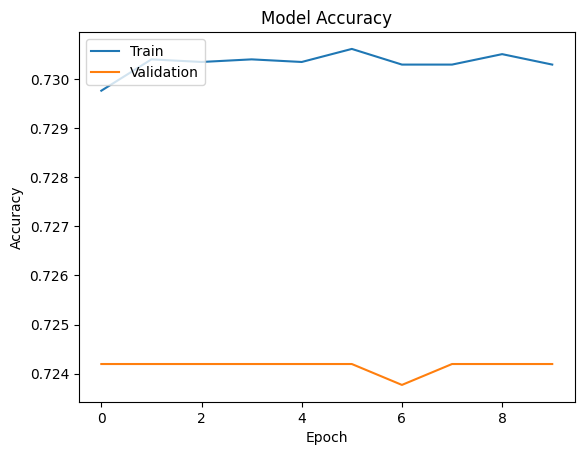

147/147 [==============================] - 2s 3ms/step


<Figure size 640x480 with 0 Axes>

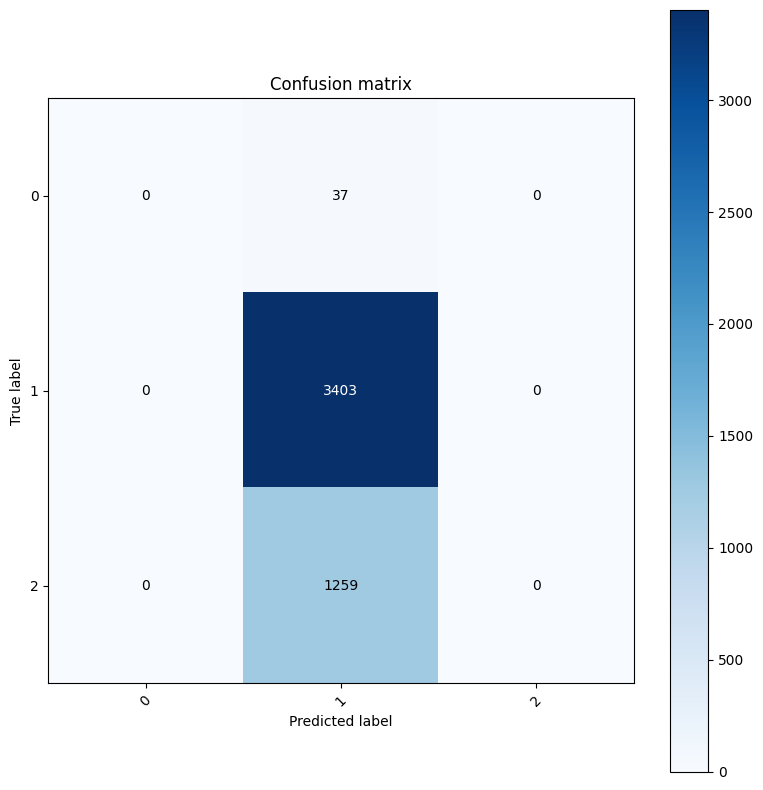

In [ ]:
# Now we start training the model and watch loss and accuracy with graphs to compare model fitting train and validation
model_7 = Model_patten(X_train_7, y_train_7, X_val_7, y_val_7)
model_7.get_loss()
model_7.get_acc()
model_7.distribution()

In [ ]:
# model_15 = Model_patten(X_train_15, y_train_15, X_val_15, y_val_15)
# model_15.get_loss()
# model_15.get_acc()

In [ ]:
# model_30 = Model_patten(X_train_30, y_train_30, X_val_30, y_val_30)
# model_30.get_loss()
# model_30.get_acc()

In [ ]:
# Similar to the train data we that the test data to convert and make the feature

test_7 = rp_7.feature_test(test_data_7)
# test_15, interval_15 = rp.feature(test_data_15, bin)
# test_30, interval_30 = rp.feature(test_data_30, bin)

(27,)


In [ ]:
test_7

,Date,Open,High,Low,Close,Adj Close,Volume,Pct_change,feature_check,feature,final_feature
23656,2022-03-07,4327.009766,4327.009766,4199.850098,4201.089844,4201.089844,6.940470e+09,-0.029518,-0.029518,4,4
23657,2022-03-08,4202.660156,4276.939941,4157.870117,4170.700195,4170.700195,7.243120e+09,-0.007234,-0.007234,4,4
23658,2022-03-09,4223.100098,4299.399902,4223.100098,4277.879883,4277.879883,5.662670e+09,0.025698,0.025698,4,4
23659,2022-03-10,4252.549805,4268.279785,4209.799805,4259.520020,4259.520020,4.980830e+09,-0.004292,-0.004292,4,4
23660,2022-03-11,4279.500000,4291.009766,4200.490234,4204.310059,4204.310059,4.938640e+09,-0.012962,-0.012962,4,4
23661,2022-03-14,4202.750000,4247.569824,4161.720215,4173.109863,4173.109863,5.574920e+09,-0.007421,-0.007421,4,4
23662,2022-03-15,4188.819824,4271.049805,4187.899902,4262.450195,4262.450195,5.392470e+09,0.021409,0.021409,4,4
23663,2022-03-16,4288.140137,4358.899902,4251.990234,4357.859863,4357.859863,6.309750e+09,0.022384,0.022384,4,4
23664,2022-03-17,4345.109863,4412.669922,4335.649902,4411.669922,4411.669922,4.985090e+09,0.012348,0.012348,4,4
23665,2022-03-18,4407.339844,4465.399902,4390.569824,4463.120117,4463.120117,8.278430e+09,0.011662,0.011662,4,4


In [ ]:
# # 提取前三高出現的數值作為模型的test data
# test_7_final_feature = test_7['feature'].value_counts().nlargest(3).index.tolist()
# test_7['final_feature'] = test_7['feature'].apply(lambda x: x if x in test_7_final_feature else np.nan)
# test_7.dropna(subset=['final_feature'], inplace=True)
# print(test_7['final_feature'].shape)

In [ ]:
# Here use the specific OneHotEncoder that we defined for the Timestep range to transform the test data
test_enc_7 = enc_7.transform(test_7['final_feature'])
# test_enc_15 = enc_15.transform(test_15['feature'])
# test_enc_30 = enc_30.transform(test_30['feature'])

# Then we slice the range Timestep to sequences
X_test_7, y_test_7 = dp.create_sequences(test_enc_7, 7)
# X_test_15, y_test_15 = dp.create_sequences(test_enc_15, 15)
# X_test_30, y_test_30 = dp.create_sequences(test_enc_30, 30)

# Now we are going to predict the value in our model
test_pred_7 = model_7.predict(X_test_7)
# test_pred_15 = model_15.predict(X_test_15)
# test_pred_30 = model_30.predict(X_test_30)

# After the predicted values here we decode the OneHotEncoder that the same transform we use
inverse_7 = enc_7.Decoder(test_pred_7)
# inverse_15 = enc_15.Decoder(test_pred_15)
# inverse_30 = enc_30.Decoder(test_pred_30)

1/1 [==============================] - 0s 21ms/step


In [ ]:
test_7.shape

(27, 11)

In [ ]:
inverse_7

array([[4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.]])

In [ ]:
i7 = rp_7.decode_replace_values(inverse_7)
i7

[array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556]),
 array([-3.55555556])]

In [ ]:
pred_7 = list()
test_d7 = test_data_7.iloc[7,:]
test_d7C = test_d7['Close']

for i in i7:
  test_d7C = test_d7C + i
  pred_7.append(test_d7C)

In [ ]:
pred_7

[array([4354.30430773]),
 array([4350.74875217]),
 array([4347.19319661]),
 array([4343.63764106]),
 array([4340.0820855]),
 array([4336.52652995]),
 array([4332.97097439]),
 array([4329.41541884]),
 array([4325.85986328]),
 array([4322.30430773]),
 array([4318.74875217]),
 array([4315.19319661]),
 array([4311.63764106]),
 array([4308.0820855]),
 array([4304.52652995]),
 array([4300.97097439]),
 array([4297.41541884]),
 array([4293.85986328]),
 array([4290.30430773]),
 array([4286.74875217])]

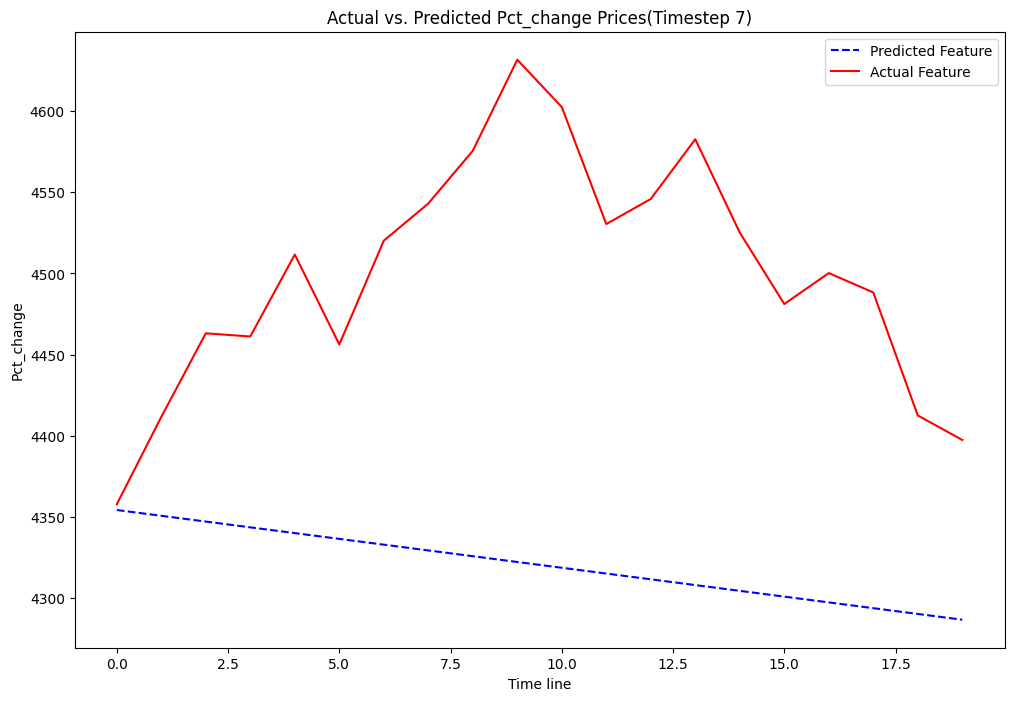

<Figure size 640x480 with 0 Axes>

In [ ]:
# Last make a graph to look the predict in our model and compare the actual happened
pg = PlotGraph()
pg.predict_graph(pred_7, Actual_feature['Close'], 7)

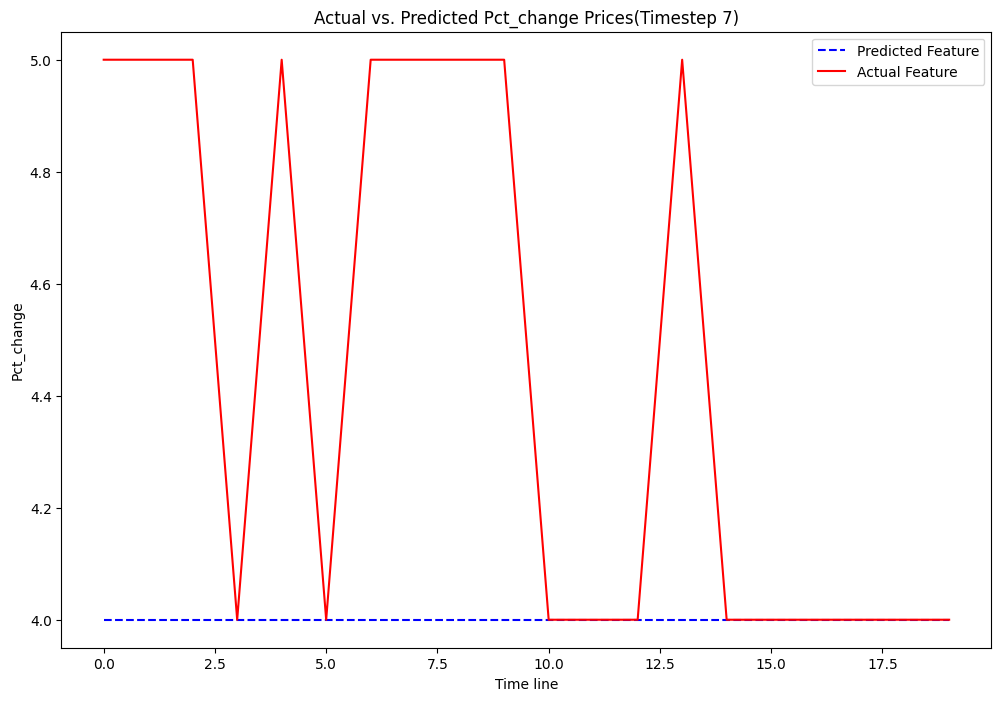

<Figure size 640x480 with 0 Axes>

In [ ]:
pg.predict_graph(inverse_7, Actual_feature['final_feature'], 7)

In [ ]:
# pg.predict_graph(inverse_30, Actual_feature['feature'], 30)